In [3]:
import re
import math
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
summary = pd.read_csv("atusdata/atussum_2013.dat")
# = pd.read_csv("atusdata/atusact_2013.dat")
# = pd.read_csv("atusdata/atuscps_2013.dat")
#respondant = pd.read_csv("atusdata/atusresp_2013.dat")
# = pd.read_csv("atusdata/atusrost_2013.dat")
# = pd.read_csv("atusdata/atusrostec_2013.dat")
# = pd.read_csv("atusdata/atussum_2013.dat")
# = pd.read_csv("atusdata/atuswho_2013.dat")

In [7]:
basic_selection = ["tucaseid", "TUFINLWGT", "TRCHILDNUM", "TEAGE", "TESEX"]

In [8]:
def average_minutes(data, activity_code):
    activity_col = "t{}".format(activity_code)
    data = data.rename(columns={"TUFINLWGT": "weight", activity_col: "minutes"})
    data = data[['weight', "minutes"]]
    data['weighted_minutes'] = data.weight * data.minutes
    return data.weighted_minutes.sum() / data.weight.sum()

In [9]:
def stdev_minutes(data, activity_code):
    data_mean = average_minutes(data, activity_code)
    num_non0_obs = summary[summary.TUFINLWGT != 0].TUFINLWGT.count()
    activity_col = "t{}".format(activity_code)
    data = data.rename(columns={"TUFINLWGT": "weight", activity_col: "minutes"})
    data = data[["weight", "minutes"]]
    data['weighted_ss'] = data.weight * (data.minutes - data_mean)**2
    return math.sqrt(data.weighted_ss.sum()/(((num_non0_obs-1)/num_non0_obs)*data.weight.sum()))

In [10]:
def activity_columns(data, activity_code):
    """For the activity code given, return all columns that fall under that activity."""
    col_prefix = "t{}".format(activity_code)
    return [column for column in data.columns if re.match(col_prefix, column)]

In [11]:
def hypothesis_test_plot(data, group_var, test_var):
    data = data[[group_var, test_var, "TUFINLWGT"]]
    data_grouped = data.groupby(group_var)
    frame = pd.DataFrame()
    for group in data_grouped:
        count = group[1].TUFINLWGT.count()
        mean = average_minutes(group[1], test_var[1:])
        stdev = stdev_minutes(group[1], test_var[1:])
        frame = frame.append({group_var: group[0], "mean": mean, "error": (stdev*1.96/math.sqrt(count))}, ignore_index=True)
    frame.index = frame.pop(group_var)
    plot = frame.plot(kind="bar", yerr="error", figsize=(12, 8))
    return (frame, plot)
    

###Household & personal organization and planning (020302) vs Television and movies (not religious) (120303)

In [12]:
current = summary[basic_selection + ["t020302", "t120303"]]

In [13]:
current_grouped = current.groupby("TESEX")
type(current_grouped)

pandas.core.groupby.DataFrameGroupBy

In [14]:
newframe = pd.DataFrame()

for group in current_grouped:
    count = group[1].TUFINLWGT.count()
    mean = average_minutes(group[1], "120303")
    stdev = stdev_minutes(group[1], "120303")
    newframe = newframe.append({"TESEX": group[0], "mean": mean, "stdev": (stdev*1.96/math.sqrt(count))}, ignore_index=True)
newframe.index = newframe.pop("TESEX")
newframe

,mean,stdev
TESEX,,
1,178.932708,5.079676
2,153.844224,3.905072


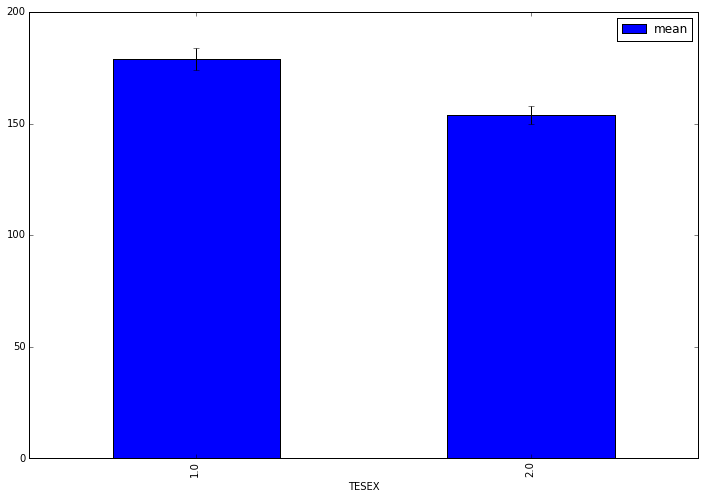

In [15]:
newframe.plot(kind="bar", yerr="stdev", figsize=(12, 8))

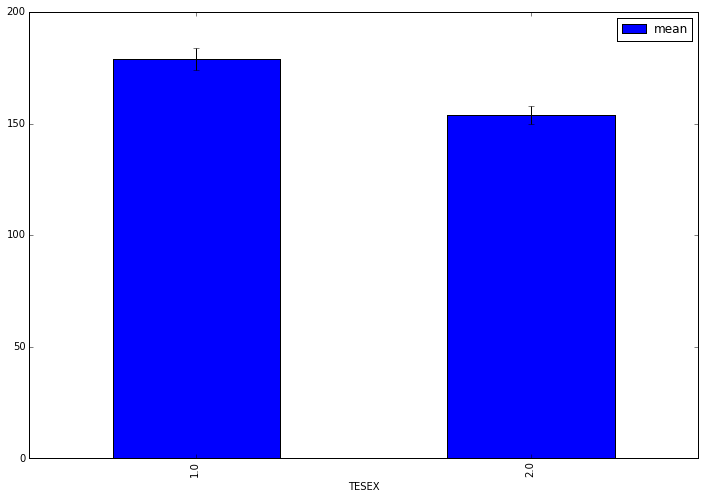

In [16]:
hypothesis_test_plot(summary, "TESEX", "t120303")[1]

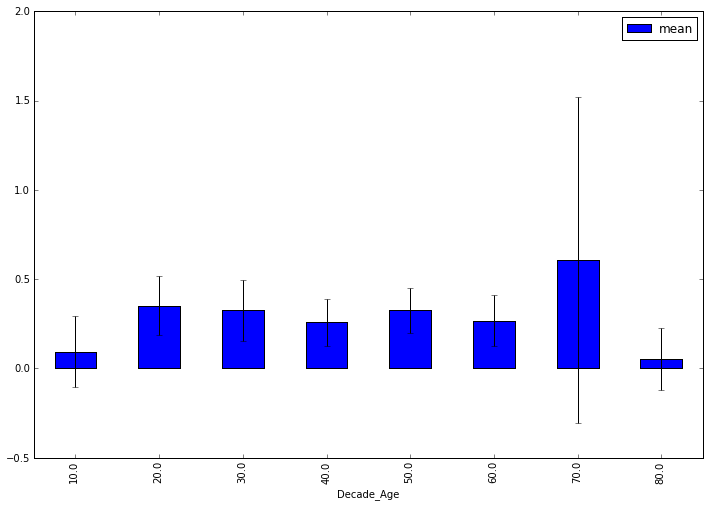

In [20]:
temp_data = summary
temp_data["Decade_Age"] = temp_data.TEAGE //10 * 10
hypothesis_test_plot(summary, "Decade_Age", "t120302")[1]